In [29]:
!pip install optuna
!pip install pytesseract
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [30]:
from classification import Setup, RoadData, RoadModel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import cv2
import pandas as pd
import numpy as np
import cv2
import pytesseract
from pathlib import Path
from color_detection import detect_traffic_light_color
from speedlimit_detection import detect_speedlimit_single

In [31]:
# the setup class takes care of data preprocessing and returns a Pandas dataframe
setup = Setup('/content/images', '/content/annotations')
train_df = setup.generate_train_df()
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,/content/images/road369.png,300,400,0,106,140,160,194,../images_resized/road369.png,"[105.0, 106.0, 145.0, 159.0]"
1,/content/images/road272.png,300,400,1,123,179,159,216,../images_resized/road272.png,"[134.0, 123.0, 161.0, 158.0]"
2,/content/images/road277.png,300,400,0,167,101,227,160,../images_resized/road277.png,"[75.0, 167.0, 119.0, 226.0]"
3,/content/images/road124.png,332,400,2,68,125,205,275,../images_resized/road124.png,"[93.0, 61.0, 206.0, 185.0]"
4,/content/images/road198.png,300,400,0,74,240,108,276,../images_resized/road198.png,"[180.0, 74.0, 206.0, 107.0]"


(400, 300, 3)


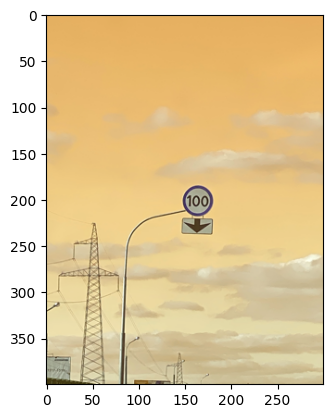

In [32]:
# show the original image
im, Y = setup.test_mask(58)
plt.imshow(im)

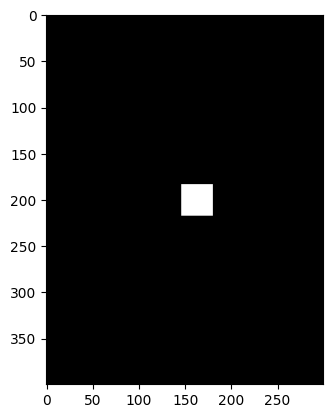

In [33]:
# prove that the image masking works
plt.imshow(Y, cmap="gray")

../images_resized/road584.png


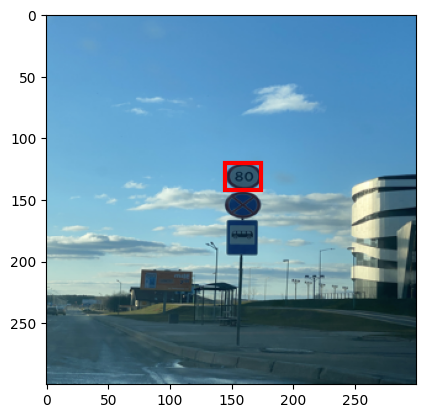

In [34]:
# show the image with bounding box drawn
number = 60
setup.test_bb(number)

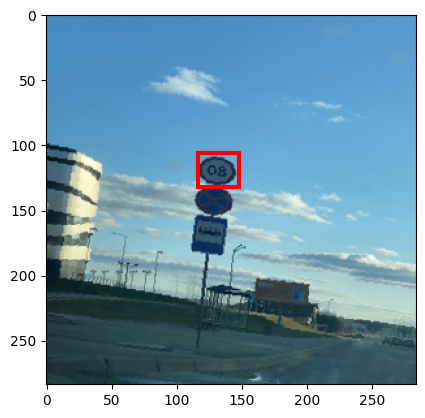

In [35]:
# show the transformed image, this one is flipped
setup.test_transforms(number)

In [36]:
# split the data into training and validation sets using sklearn
train_df = train_df.reset_index()
X = train_df[['new_path', 'new_bb']]
Y = train_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [37]:
# custom dataset from the RoadData class in classifications.py
train_ds = RoadData(X_train['new_path'], X_train['new_bb'], Y_train, setup, is_transforms=True)
valid_ds = RoadData(X_val['new_path'], X_val['new_bb'], Y_val, setup)

In [38]:
# PyTorch's DataLoader to iterate over the data
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# function to train the model (called once an epoch)
def train(network, optimizer, dl):
    network.train()
    total = 0
    sum_loss = 0

    for x, y_class, y_bb in dl:
        len_batch = y_class.shape[0]
        x = x.to(device).float()
        y_class = y_class.to(device)
        y_bb = y_bb.to(device).float()
        out_class, out_bb = network(x)

        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
        loss = loss_class + loss_bb

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += len_batch
        sum_loss += loss.item()

    train_loss = sum_loss / total
    return train_loss


cuda


In [40]:
# function to test the network each epoch
def test(network, dl):
    network.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y_class, y_bb in dl:
            len_batch = y_class.shape[0]
            x = x.to(device).float()
            y_class = y_class.to(device)
            y_bb = y_bb.to(device).float()

            out_class, out_bb = network(x)

            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb

            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()

            val_sum_loss += loss.item()
            val_total += len_batch

        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total

    return val_acc


In [41]:
# objective function to be passed to optuna
def objective(trial):
    # choose between resnet models (resnet34 or resnet50)
    net = trial.suggest_categorical("net", ["resnet34", "resnet50"])

    model = RoadModel(net).to(device)
    params = [p for p in model.parameters() if p.requires_grad]

    # choose optimizer (Adam, RMSprop, stochastic gradient descent)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    # choose learning rate between 0.001 and 1
    lr = trial.suggest_float("lr", 1e-3, 1)
    optimizer = getattr(torch.optim, optimizer_name)(params, lr=lr)

    for epoch in range(n_epochs):
        train(model, optimizer, train_dl)
        loss = test(model, valid_dl)

        trial.report(loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return loss

In [55]:
n_epochs = 15
number_of_trials = 15
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [62]:
# start the study to maximize the objective function, which outputs the accuracy of the model
# as mentioned in the video, the objective function is something we would improve if given more time by using
# intersection over union and mean average precision metrics
study = optuna.create_study(direction="maximize", study_name="roadsignclass")
study.optimize(objective, n_trials=number_of_trials)

[I 2023-12-06 01:02:13,720] A new study created in memory with name: roadsignclass
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[I 2023-12-06 01:06:00,921] Trial 0 finished with value: 0.09090909090909091 and parameters: {'net': 'resnet50', 'optimizer': 'Adam', 'lr': 0.6434352639555576}. Best is trial 0 with value: 0.09090909090909091.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarnin

In [63]:
# print the optimal hyperparameters
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  15
  Number of pruned trials:  7
  Number of complete trials:  8
Best trial:
  Value:  0.7272727272727273
  Params: 
    net: resnet50
    optimizer: SGD
    lr: 0.03636026437734676


In [64]:
resnet = trial.params['net']

model = RoadModel(resnet).to(device)
params = [p for p in model.parameters() if p.requires_grad]
lr = trial.params['lr']
optimizer = getattr(torch.optim, trial.params['optimizer'])(params, lr=lr)

In [65]:
# train model based on best hyperparameters from optuna
for epoch in range(n_epochs):
  train(model, optimizer, train_dl)
  test(model, valid_dl)

In [241]:
im_num = 11

im = cv2.cvtColor(cv2.imread('../images_resized/road{}.png'.format(im_num)), cv2.COLOR_BGR2RGB)
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite('./road_signs_test/road{}.jpg'.format(im_num), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [242]:
test_ds = RoadData(
    pd.DataFrame([{'path':'./road_signs_test/road{}.jpg'.format(im_num)}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y'],
    setup
)

In [243]:
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])

In [244]:
# inference
model.eval()
out_class, out_bb = model(xx.to(device))
out_class, out_bb

(tensor([[ 1.3862, -0.8482, -0.0420, -0.5411]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[ 80.3979,  94.3190, 130.8924, 165.5717]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [245]:
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([1.3862], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

In [246]:
# copied from Setup class
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
class_dict

{'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}

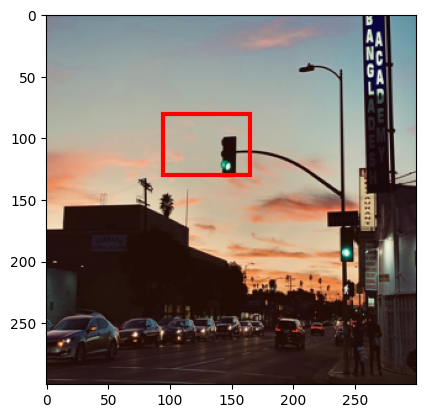

In [250]:
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
setup.show_corner_bb(im, bb_hat[0])

In [249]:
color = detect_traffic_light_color(im, [bb_hat[0][1], bb_hat[0][0], bb_hat[0][3], bb_hat[0][2]])
color

'green'

In [411]:
im_num = 465
im = cv2.cvtColor(cv2.imread('../images_resized/road{}.png'.format(im_num)), cv2.COLOR_BGR2RGB)
test_ds = RoadData(
    pd.DataFrame([{'path':'./road_signs_test/road{}.jpg'.format(im_num)}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y'],
    setup
)

model.to("cpu").eval()
out_class, out_bb = model(xx.to("cpu"))
out_class, out_bb

(tensor([[ 1.3862, -0.8482, -0.0420, -0.5411]], grad_fn=<AddmmBackward0>),
 tensor([[ 80.3979,  94.3190, 130.8924, 165.5717]], grad_fn=<AddmmBackward0>))

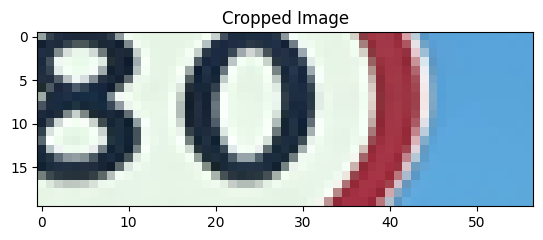

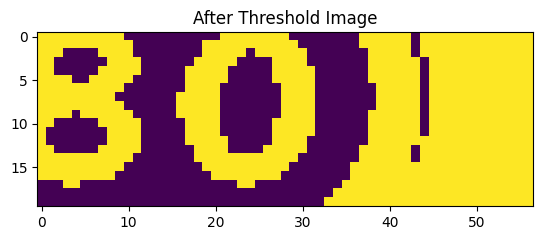

30


'30'

In [412]:
# in this case, the model did not predict the bounding box well enough, and the speed limit detection turned an '8' into a '3'
# this shows that the accuracy of the speedlimit and color detection models are based on how well the model predicts the bounding box for the image
# as we described in our video, this is something we would improve if given more time
speedlimit = detect_speedlimit_single('../images_resized/road{}.png'.format(im_num), [bb_hat[0][1], bb_hat[0][0], bb_hat[0][3], bb_hat[0][2]])
speedlimit